#### Chains in LangGraph

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
groq_api_key = os.getenv("GROQ_API_KEY")

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Hi, What's on your mind?", name="LLM")]
messages.append(HumanMessage(content=f"Help me in doing simple calculations.", name="Soham"))
messages.append(AIMessage(content=f"Sure! Let's start calculating!", name="LLM"))
messages.append(HumanMessage(content=f"What is 20 plus 3", name="Soham"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hi, What's on your mind?
================================ Human Message =================================
Name: Soham

Help me in doing simple calculations.
================================== Ai Message ==================================
Name: LLM

Sure! Let's start calculating!
================================ Human Message =================================
Name: Soham

What is 20 plus 3


In [33]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")

In [4]:
result = llm.invoke(messages)

In [5]:
result

AIMessage(content='\n<think>\nOkay, the user asked "What is 20 plus 3". Let me break this down. They want a simple calculation. First, I need to confirm the numbers involved. 20 and 3. Addition is straightforward here. \n\nWait, 20 plus 3. Let me visualize it. If you have 20 items and add 3 more, the total should be 23. But I should double-check to avoid any mistakes. Maybe count up from 20: 21, 22, 23. That\'s three numbers, so yes, 23.\n\nIs there any chance they might need it in a different format? Like written out? Probably not necessary unless specified. The user just asked for the result. \n\nAlso, considering the previous messages, the user had asked for help with simple calculations, so this is a follow-up. The response should be quick and to the point. No need for extra explanations unless they ask for more details. \n\nHmm, maybe they want to confirm if I can handle basic math. Let me make sure there\'s no trick here. 20 +3 is definitely 23. Alright, I\'ll just provide the an

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 276,
  'prompt_tokens': 60,
  'total_tokens': 336,
  'completion_time': 0.646845794,
  'prompt_time': 0.00590814,
  'queue_time': 0.045756672,
  'total_time': 0.652753934},
 'model_name': 'qwen-qwq-32b',
 'system_fingerprint': 'fp_6b36369676',
 'finish_reason': 'stop',
 'logprobs': None}

In [7]:
result.pretty_print()

================================== Ai Message ==================================


<think>
Okay, the user asked "What is 20 plus 3". Let me break this down. They want a simple calculation. First, I need to confirm the numbers involved. 20 and 3. Addition is straightforward here. 

Wait, 20 plus 3. Let me visualize it. If you have 20 items and add 3 more, the total should be 23. But I should double-check to avoid any mistakes. Maybe count up from 20: 21, 22, 23. That's three numbers, so yes, 23.

Is there any chance they might need it in a different format? Like written out? Probably not necessary unless specified. The user just asked for the result. 

Also, considering the previous messages, the user had asked for help with simple calculations, so this is a follow-up. The response should be quick and to the point. No need for extra explanations unless they ask for more details. 

Hmm, maybe they want to confirm if I can handle basic math. Let me make sure there's no trick here. 20 +3 i

#### Tools in LangGraph

In [34]:
def add(a:int, b:int)-> int:
    """
    Add a and b
    args:
        a (int): first integer
        b (int): second integer
    returns:
        int
    """
    return a+b

In [36]:
llm_with_tool = llm.bind_tools([add])
tool_call = llm_with_tool.invoke([HumanMessage(content=f"What is 3+4", name="Soham")])

In [19]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 4},
  'id': '5mkm6senx',
  'type': 'tool_call'}]

In [38]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [39]:
initial_messages = [AIMessage(content=f"Hi, What's in your mind?", name="LLM")]
initial_messages.append(HumanMessage(content=f"Help me in doing simple calculations.", name="Soham"))
initial_messages

[AIMessage(content="Hi, What's in your mind?", additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='Help me in doing simple calculations.', additional_kwargs={}, response_metadata={}, name='Soham')]

In [40]:
ai_message = AIMessage(content=f"Sure! Let's start calculating!", name="LLM")
ai_message

AIMessage(content="Sure! Let's start calculating!", additional_kwargs={}, response_metadata={}, name='LLM')

In [41]:
add_messages(initial_messages, ai_message)

[AIMessage(content="Hi, What's in your mind?", additional_kwargs={}, response_metadata={}, name='LLM', id='aca0314f-c2ce-481f-9999-901b4684a129'),
 HumanMessage(content='Help me in doing simple calculations.', additional_kwargs={}, response_metadata={}, name='Soham', id='e0cda92a-d93f-4436-8bb1-925246583a7c'),
 AIMessage(content="Sure! Let's start calculating!", additional_kwargs={}, response_metadata={}, name='LLM', id='b3a3e8bf-3685-4ce9-ab8c-6cbf4dc0fd21')]

In [42]:
def llm_tool(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

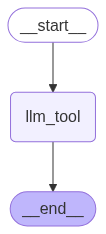

In [43]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
msgs = graph.invoke({"messages":"What is 30+39"})
for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 30+39
================================== Ai Message ==================================
Tool Calls:
  add (591wqs4h7)
 Call ID: 591wqs4h7
  Args:
    a: 30
    b: 39


In [45]:
tools = [add]

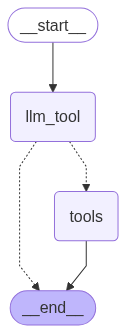

In [46]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools",END)
graph_builder = builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [47]:
msgs = graph_builder.invoke({"messages":"What is 20 plus 49"})
for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 20 plus 49
================================== Ai Message ==================================
Tool Calls:
  add (q63k5tynz)
 Call ID: q63k5tynz
  Args:
    a: 20
    b: 49
================================= Tool Message =================================
Name: add

69


In [48]:
msgs = graph_builder.invoke({"messages":"Which LLM model are you?"})
for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Which LLM model are you?
================================== Ai Message ==================================

I am Qwen, a large language model developed by Alibaba Cloud. How can I assist you today?
